In [1]:
import os
import json

In [2]:
def returnTag(corpus):
    tags = []
    for workflow in corpus:
        workflow_tags = workflow['tags']
        if(len(workflow_tags) == 0):
            tags.append('no_tag')
            continue
        for worflow_tag in workflow_tags:
            tags.append(worflow_tag)
    return ' '.join(tags)

In [3]:
file = open('..\\workflows_galaxy\\00a4dbc9329c638b.json')
workflow_json = json.load(file)
#workflow_content = str(workflow_json)
#workflow_content = workflow_content.replace("'","").replace('{','').replace('}','').replace('\\','').replace("\"",'').replace(',','').replace(':','')
#workflow_content = ' '.join(workflow_content.split())

In [4]:
workflow_json['tags']

[]

In [5]:
corpus = []
corpus_json = []

for file_name in os.listdir("..\\workflows_galaxy"):
    file_path = f'..\\workflows_galaxy\\{file_name}'
    if(os.path.exists(file_path)):
        file = open(file_path)
        workflow_json = json.load(file)
        workflow_content = str(workflow_json)
        workflow_content = workflow_content.replace("'","").replace('{','').replace('}','').replace('\\','').replace("\"",'').replace(',','').replace(':','')
        workflow_content = ' '.join(workflow_content.split())
        corpus_json.append(workflow_json)
        corpus.append(workflow_content)
        

## TF-IDF 

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=1)
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()

array(['000', '0000', '000000000', ..., '２１３１２', 'ａｓｄａ', 'ｆｄｓａｄ'],
      dtype=object)

In [7]:
X.shape

(1014, 84537)

## TF-IDF PCA

In [8]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
corpus_pca = pca.fit_transform(X.toarray())

In [9]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.06729204 0.05958181 0.02829634]
[6.56164276 6.17429782 4.25496413]


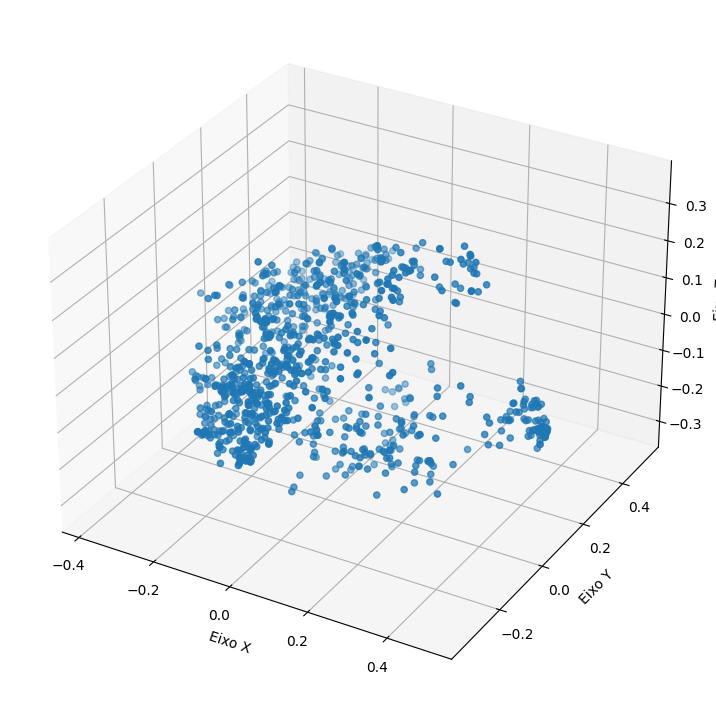

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

#ex_variance=np.var(X_pca,axis=0)
#ex_variance_ratio = ex_variance/np.sum(ex_variance)
#ex_variance_ratio

Xax = corpus_pca[:,0]
Yax = corpus_pca[:,1]
Zax = corpus_pca[:,2]


fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection='3d')

ax.scatter(Xax, Yax, Zax)

# Defina rótulos para os eixos
ax.set_xlabel('Eixo X')
ax.set_ylabel('Eixo Y')
ax.set_zlabel('Eixo Z')

# Mostre o gráfico
plt.show()

## MeanShift TF-IDF

In [11]:
from sklearn.cluster import MeanShift
bandwidth_tfidf = 0.2
ms_tfidf = MeanShift(bandwidth=bandwidth_tfidf)
ms_tfidf.fit(corpus_pca) 
np.unique(ms_tfidf.labels_)

array([0, 1, 2, 3], dtype=int64)

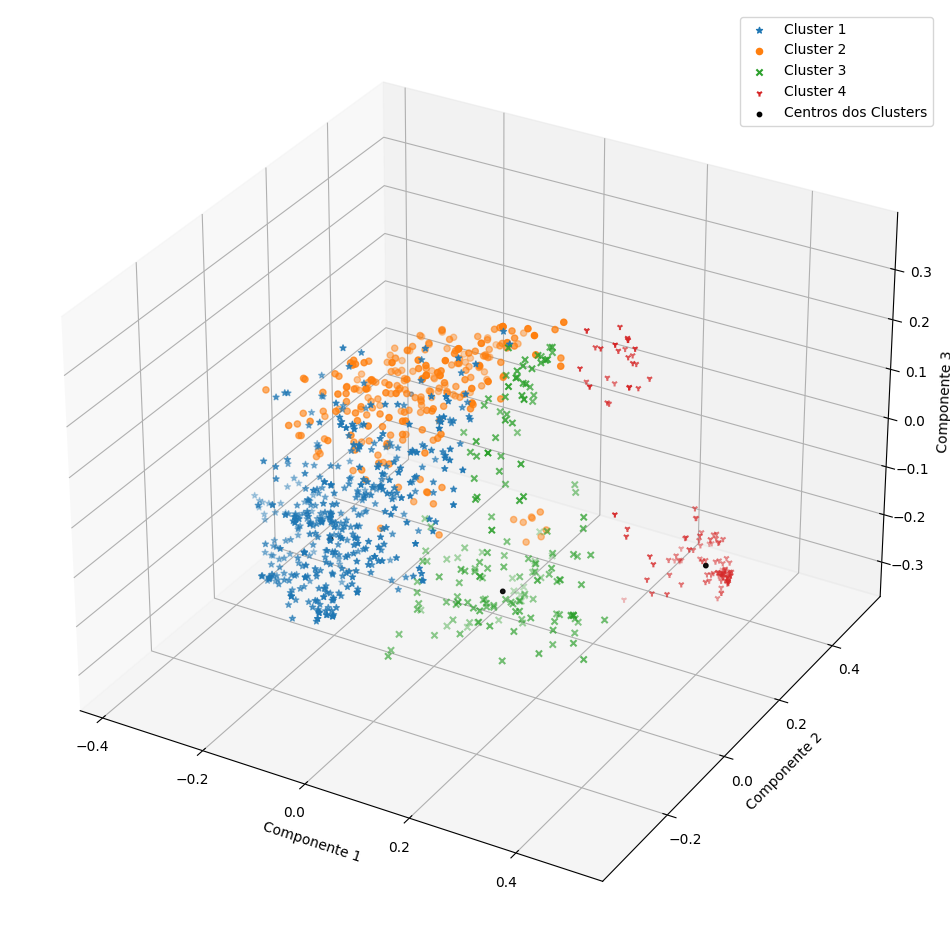

In [12]:
#Cluster para cada observação
labels = ms_tfidf.labels_

#Centro de cada cluster
cluster_centers = ms_tfidf.cluster_centers_

#Verifica quantos clusters foram encontrados
n_clusters = len(np.unique(labels))

fig = plt.figure(figsize=(12, 20))
ax = fig.add_subplot(projection='3d')

marker={0:'*',1:'o',2:'x',3:'1',4:'2',5:'3',6:'4',7:'p',8:'s'}
for i in range(n_clusters):
    cluster = corpus_pca[labels == i]
    ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], label=f'Cluster {i + 1}',marker=marker[i])

ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2],
           s=10, color='black', label='Centros dos Clusters')

# Defina rótulos para os eixos
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')

# Adicione uma legenda
ax.legend()

# Mostre o gráfico
plt.show()

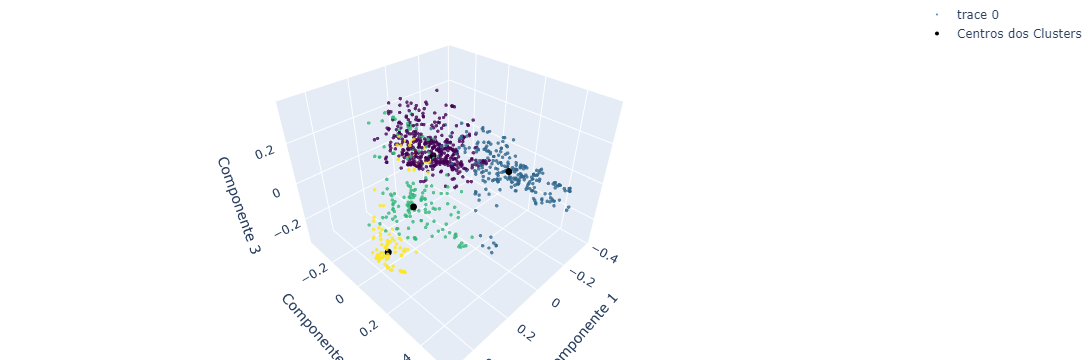

In [13]:
import plotly.graph_objs as go
from sklearn.cluster import MeanShift

# Criar um gráfico 3D interativo com Plotly
trace1 = go.Scatter3d(
    x= corpus_pca[:, 0],
    y= corpus_pca[:, 1],
    z= corpus_pca[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        opacity=0.8,
        color=labels,  # Cor por rótulo de cluster
        colorscale='Viridis',  # Escolha de cores
    ),
    text=labels,  # Rótulos de texto com base nos rótulos de cluster
)

trace2 = go.Scatter3d(
    x=cluster_centers[:, 0],
    y=cluster_centers[:, 1],
    z=cluster_centers[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        symbol='circle',
        opacity=1,
        color='black',  # Cor dos centros dos clusters
    ),
    name='Centros dos Clusters',
)

layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(title='Componente 1'),
        yaxis=dict(title='Componente 2'),
        zaxis=dict(title='Componente 3'),
    ),
)

data = [trace1, trace2]

fig = go.Figure(data=data, layout=layout)

# Exibir o gráfico interativo no notebook ou em um arquivo HTML
fig.show(renderer = "jupyterlab")

Cluster: 0  range: [0-457)


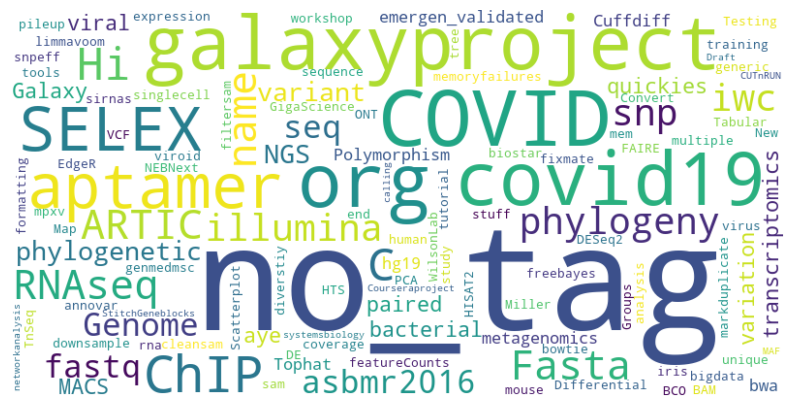

Cluster: 1  range: [457-725)


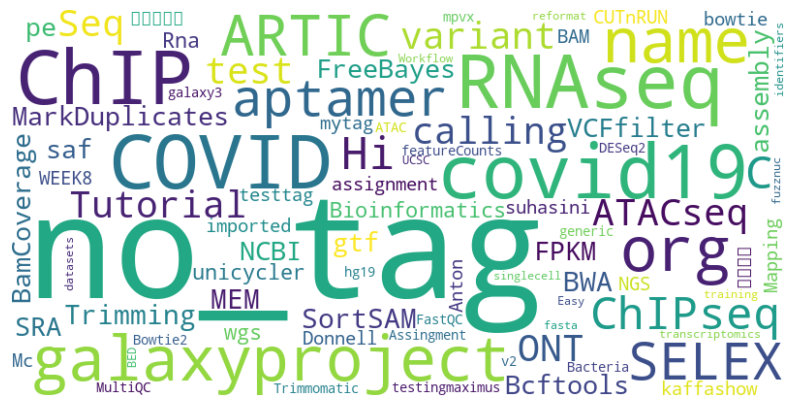

Cluster: 2  range: [725-893)


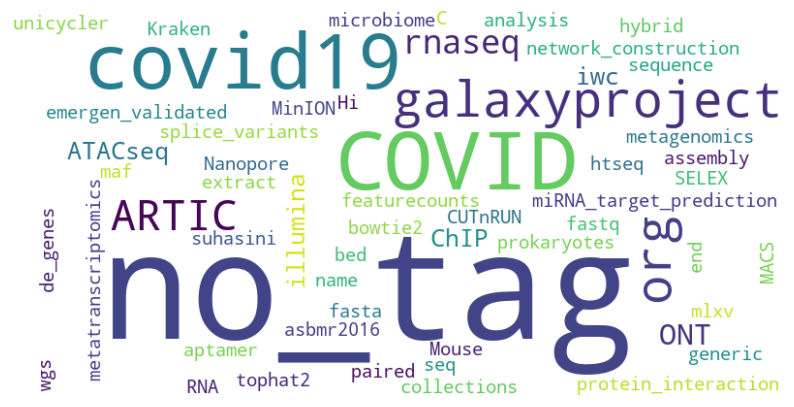

Cluster: 3  range: [893-1014)


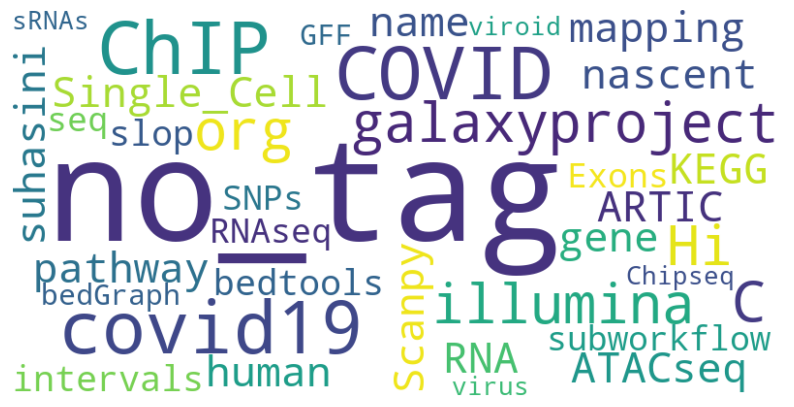

In [14]:
from wordcloud import WordCloud
li = 0
ls = 0
for i in range(n_clusters):
    range_cluster = len(corpus_pca[labels == i])
    ls = li + range_cluster
    print(f'Cluster: {i}  range: [{li}-{ls})')
    wordcloud = WordCloud(width=800, height=400, background_color="white",collocations=False).generate(returnTag(corpus_json[li:ls]))
    # Exiba a nuvem de palavras
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    li = ls

## Word2Vec

In [15]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [16]:
corpus_w2v = []
for workflow in corpus:
    corpus_w2v.append(workflow.split())

In [17]:
w2vmodel = Word2Vec(corpus_w2v, vector_size=100, window=5, min_count=1, sg=0)
w2vmodel.train(corpus_w2v, total_examples=len(corpus_w2v), epochs=500)

(458696628, 745563500)

In [18]:
w2vmean = []
nomatch = 0
match = 0
for phrase in corpus:
    phrase = phrase.split()
    w2vsum = np.zeros(100)
    if len(phrase) > 0:
        for word in phrase:
            try:
                w2vsum = w2vsum + w2vmodel.wv[word]
                match += 1
            except KeyError:
                nomatch += 1
        w2vmean.append(w2vsum/len(phrase))
print(f'Matches: {match} => {match/(match+nomatch)}')
print(f'No Matches: {nomatch} => {nomatch/(match+nomatch)}')

Matches: 1491127 => 1.0
No Matches: 0 => 0.0


## Word2Vec PCA

In [19]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
corpus_pca_w2v = pca.fit_transform(w2vmean)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.32301383 0.16915577 0.12494499]
[70.76558325 51.21001848 44.01198501]


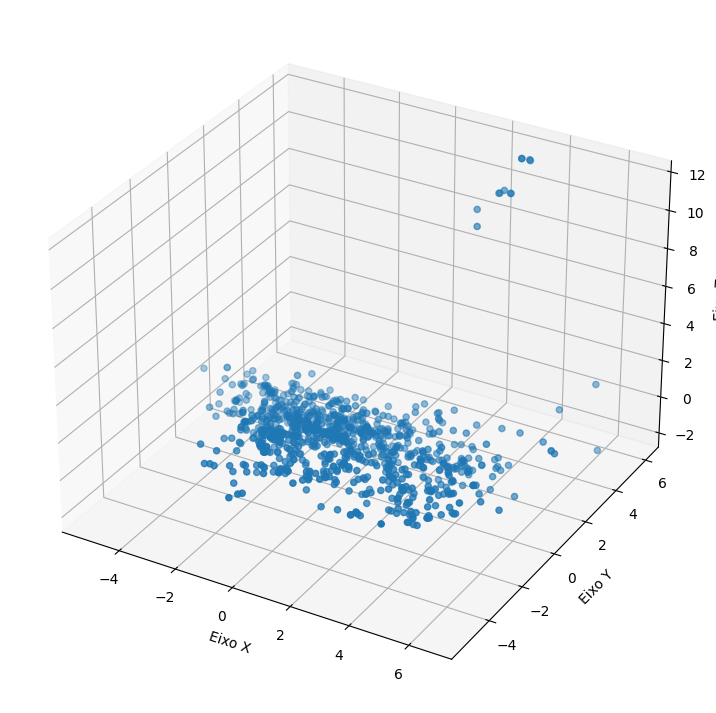

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

Xax = corpus_pca_w2v[:,0]
Yax = corpus_pca_w2v[:,1]
Zax = corpus_pca_w2v[:,2]

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection='3d')

ax.scatter(Xax, Yax, Zax)

# Defina rótulos para os eixos
ax.set_xlabel('Eixo X')
ax.set_ylabel('Eixo Y')
ax.set_zlabel('Eixo Z')

# Mostre o gráfico
plt.show()

## MeanShift Word2Vec

In [21]:
from sklearn.cluster import MeanShift
bandwidth_w2v = 2
ms_w2v = MeanShift(bandwidth=bandwidth_w2v)
ms_w2v.fit(corpus_pca_w2v) 
np.unique(ms_w2v.labels_)

array([0, 1, 2, 3], dtype=int64)

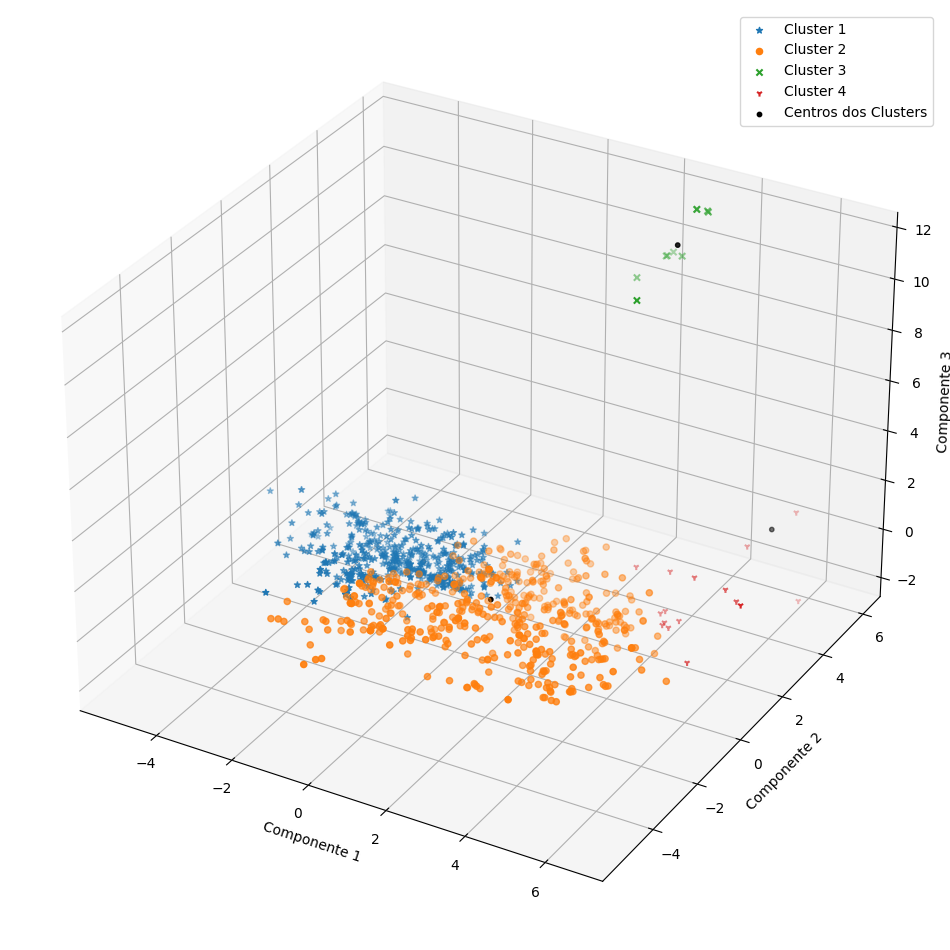

In [22]:
#Cluster para cada observação
labels = ms_w2v.labels_

#Centro de cada cluster
cluster_centers = ms_w2v.cluster_centers_

#Verifica quantos clusters foram encontrados
n_clusters = len(np.unique(labels))

fig = plt.figure(figsize=(12, 20))
ax = fig.add_subplot(projection='3d')

marker={0:'*',1:'o',2:'x',3:'1',4:'2',5:'3',6:'4',7:'p',8:'s'}
for i in range(n_clusters):
    cluster = corpus_pca_w2v[labels == i]
    ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], label=f'Cluster {i + 1}',marker=marker[i])

ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2],
           s=10, color='black', label='Centros dos Clusters')

# Defina rótulos para os eixos
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')

# Adicione uma legenda
ax.legend()

# Mostre o gráfico
plt.show()

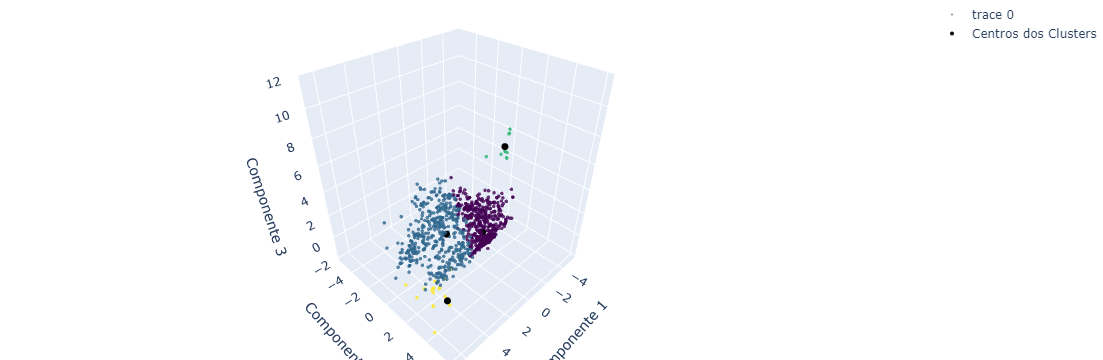

In [23]:
import plotly.graph_objs as go
from sklearn.cluster import MeanShift

# Criar um gráfico 3D interativo com Plotly
trace1 = go.Scatter3d(
    x= corpus_pca_w2v[:, 0],
    y= corpus_pca_w2v[:, 1],
    z= corpus_pca_w2v[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        opacity=0.8,
        color=labels,  # Cor por rótulo de cluster
        colorscale='Viridis',  # Escolha de cores
    ),
    text=labels,  # Rótulos de texto com base nos rótulos de cluster
)

trace2 = go.Scatter3d(
    x=cluster_centers[:, 0],
    y=cluster_centers[:, 1],
    z=cluster_centers[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        symbol='circle',
        opacity=1,
        color='black',  # Cor dos centros dos clusters
    ),
    name='Centros dos Clusters',
)

layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(title='Componente 1'),
        yaxis=dict(title='Componente 2'),
        zaxis=dict(title='Componente 3'),
    ),
)

data = [trace1, trace2]

fig = go.Figure(data=data, layout=layout)

# Exibir o gráfico interativo no notebook ou em um arquivo HTML
fig.show(renderer = "jupyterlab")

Cluster: 0  range: [0-501)


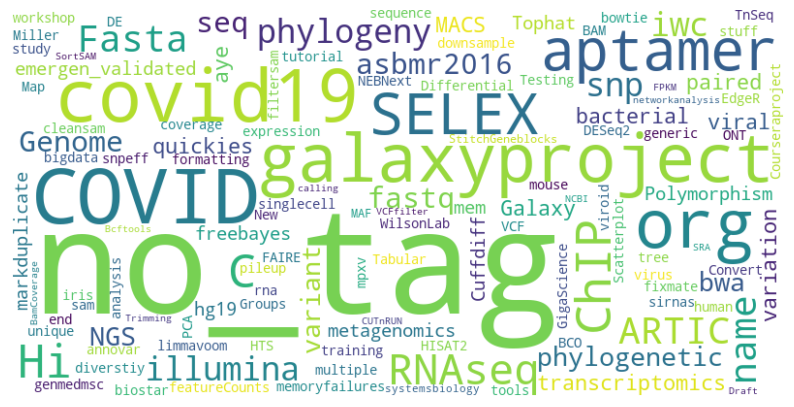

Cluster: 1  range: [501-986)


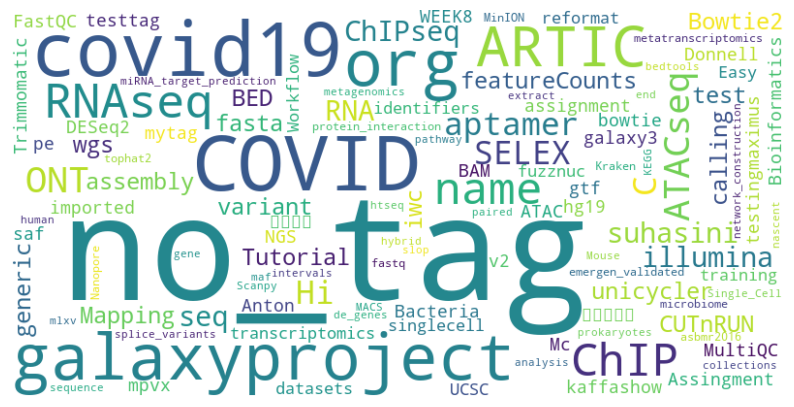

Cluster: 2  range: [986-997)


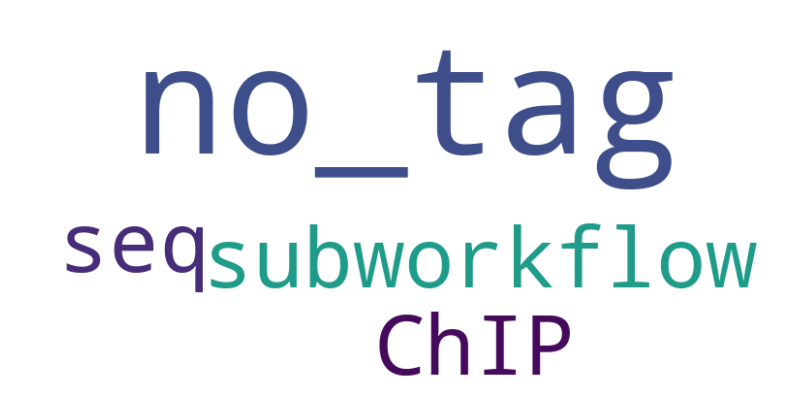

Cluster: 3  range: [997-1014)


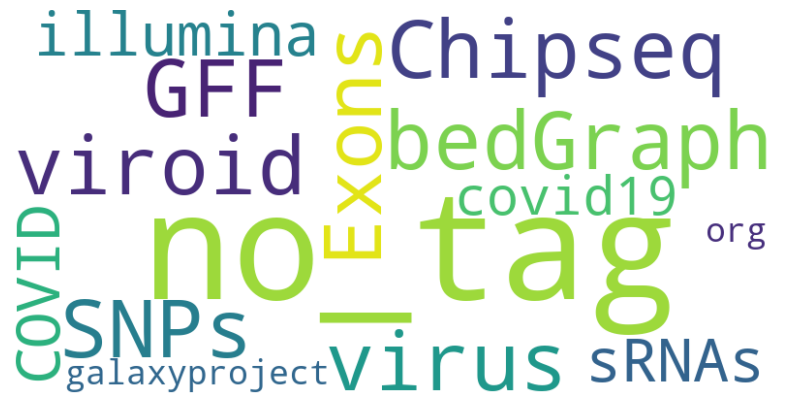

In [24]:
from wordcloud import WordCloud
li = 0
ls = 0
for i in range(n_clusters):
    range_cluster = len(corpus_pca_w2v[labels == i])
    ls = li + range_cluster
    print(f'Cluster: {i}  range: [{li}-{ls})')
    wordcloud = WordCloud(width=800, height=400, background_color="white",collocations=False).generate(returnTag(corpus_json[li:ls]))
    # Exiba a nuvem de palavras
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    li = ls

## FastText

In [25]:
from gensim.models import FastText

tokenized_corpus = [text.split() for text in corpus]

ftmodel = FastText(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, sg=1)
ftmodel.train(tokenized_corpus, total_examples=len(tokenized_corpus), epochs=5)

(4585611, 7455635)

In [26]:
ftmean = []
nomatch = 0
match = 0
for phrase in corpus:
    phrase = phrase.split()
    ftsum = np.zeros(100)
    if len(phrase) > 0:
        for word in phrase:
            try:
                ftsum = ftsum + ftmodel.wv[word]
                match += 1
            except KeyError:
                nomatch += 1
        ftmean.append(ftsum/len(phrase))
print(f'Matches: {match} => {match/(match+nomatch)}')
print(f'No Matches: {nomatch} => {nomatch/(match+nomatch)}')

Matches: 1491127 => 1.0
No Matches: 0 => 0.0


## FastText PCA

In [27]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
corpus_pca_ft = pca.fit_transform(ftmean)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.21890958 0.16222189 0.14101876]
[10.70789815  9.21778513  8.59429564]


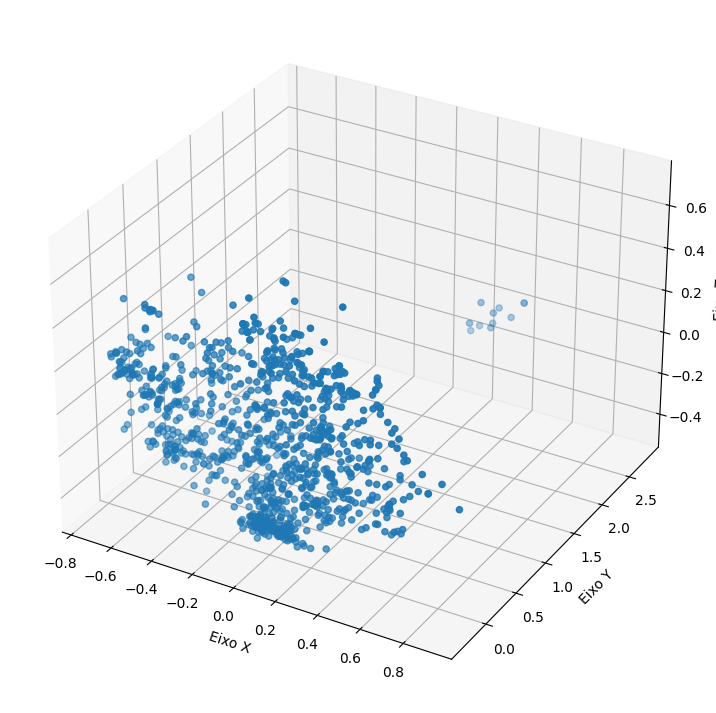

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

Xax = corpus_pca_ft[:,0]
Yax = corpus_pca_ft[:,1]
Zax = corpus_pca_ft[:,2]

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection='3d')

ax.scatter(Xax, Yax, Zax)

ax.set_xlabel('Eixo X')
ax.set_ylabel('Eixo Y')
ax.set_zlabel('Eixo Z')

plt.show()

## FastText MeanShit

In [29]:
from sklearn.cluster import MeanShift
bandwidth_ft = 0.9
ms_ft = MeanShift(bandwidth=bandwidth_ft)
ms_ft.fit(corpus_pca_ft) 
np.unique(ms_ft.labels_)

array([0, 1], dtype=int64)

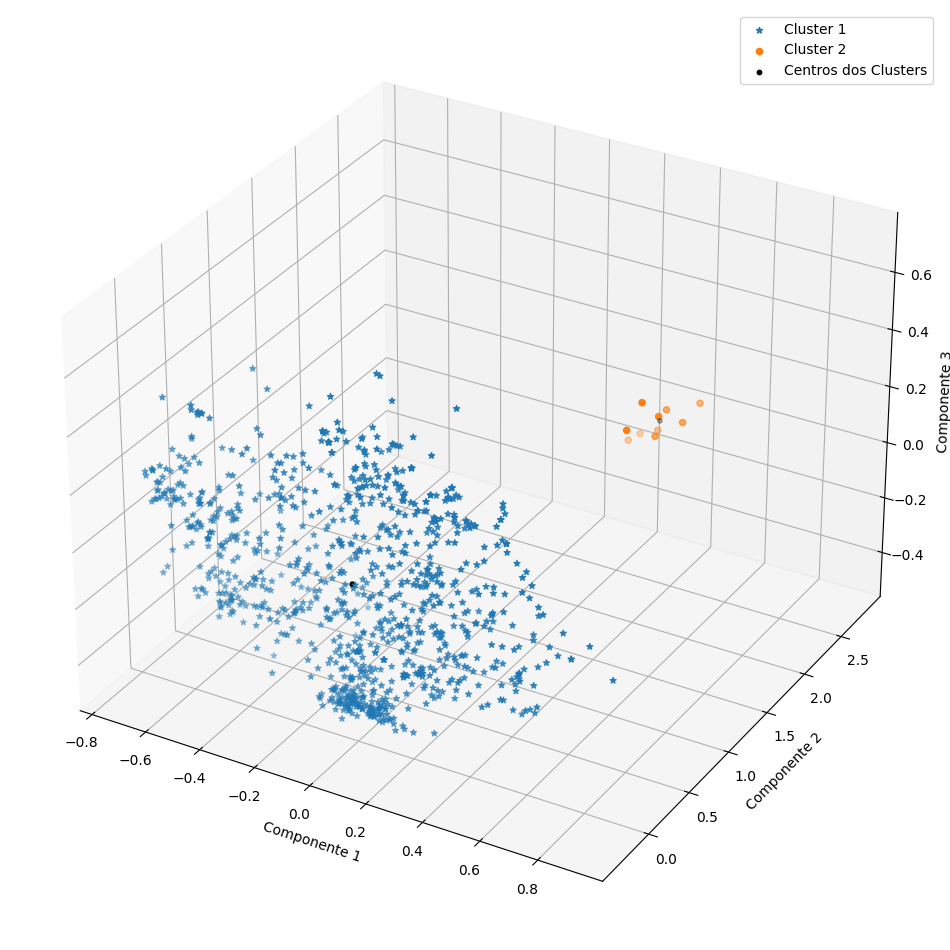

In [30]:
#Cluster para cada observação
labels = ms_ft.labels_

#Centro de cada cluster
cluster_centers = ms_ft.cluster_centers_

#Verifica quantos clusters foram encontrados
n_clusters = len(np.unique(labels))

fig = plt.figure(figsize=(12, 20))
ax = fig.add_subplot(projection='3d')

marker={0:'*',1:'o',2:'x',3:'1',4:'2',5:'3',6:'4',7:'p',8:'s'}
for i in range(n_clusters):
    cluster = corpus_pca_ft[labels == i]
    ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], label=f'Cluster {i + 1}',marker=marker[i])

ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2],
           s=10, color='black', label='Centros dos Clusters')

# Defina rótulos para os eixos
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')

# Adicione uma legenda
ax.legend()

# Mostre o gráfico
plt.show()

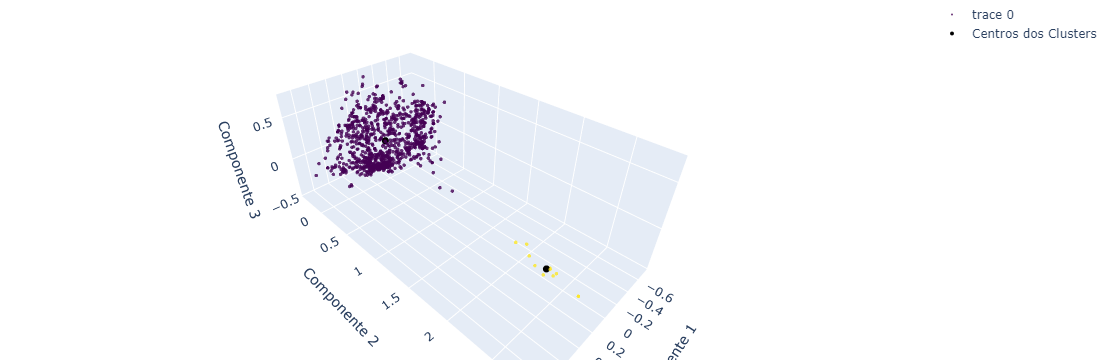

In [31]:
import plotly.graph_objs as go
from sklearn.cluster import MeanShift

# Criar um gráfico 3D interativo com Plotly
trace1 = go.Scatter3d(
    x= corpus_pca_ft[:, 0],
    y= corpus_pca_ft[:, 1],
    z= corpus_pca_ft[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        opacity=0.8,
        color=labels,  # Cor por rótulo de cluster
        colorscale='Viridis',  # Escolha de cores
    ),
    text=labels,  # Rótulos de texto com base nos rótulos de cluster
)

trace2 = go.Scatter3d(
    x=cluster_centers[:, 0],
    y=cluster_centers[:, 1],
    z=cluster_centers[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        symbol='circle',
        opacity=1,
        color='black',  # Cor dos centros dos clusters
    ),
    name='Centros dos Clusters',
)

layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(title='Componente 1'),
        yaxis=dict(title='Componente 2'),
        zaxis=dict(title='Componente 3'),
    ),
)

data = [trace1, trace2]

fig = go.Figure(data=data, layout=layout)

# Exibir o gráfico interativo no notebook ou em um arquivo HTML
fig.show(renderer = "jupyterlab")

Cluster: 0  range: [0-1003)


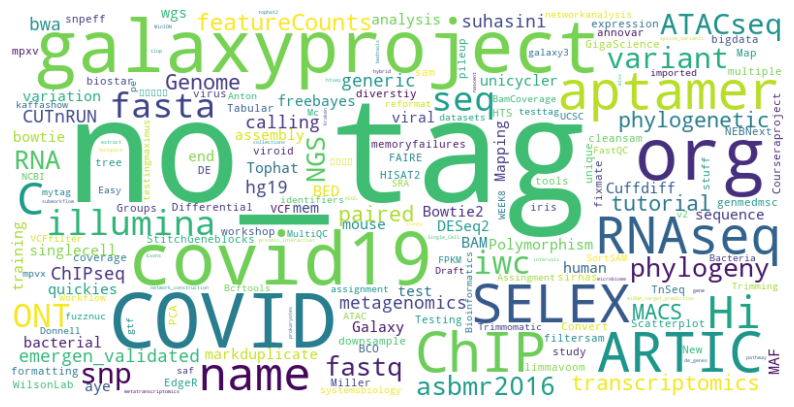

Cluster: 1  range: [1003-1014)


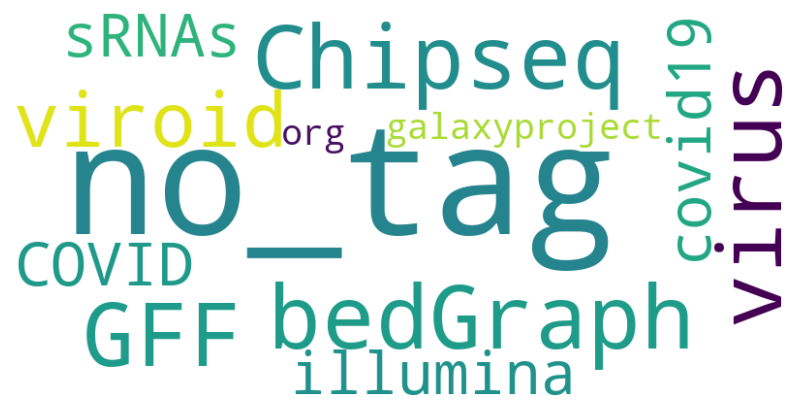

In [32]:
from wordcloud import WordCloud
li = 0
ls = 0
for i in range(n_clusters):
    range_cluster = len(corpus_pca_ft[labels == i])
    ls = li + range_cluster
    print(f'Cluster: {i}  range: [{li}-{ls})')
    wordcloud = WordCloud(width=800, height=400, background_color="white",collocations=False).generate(returnTag(corpus_json[li:ls]))
    # Exiba a nuvem de palavras
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    li = ls